## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

Populating the interactive namespace from numpy and matplotlib


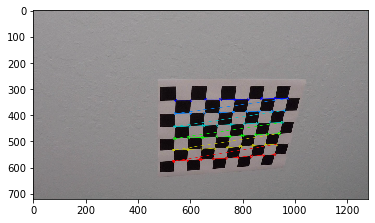

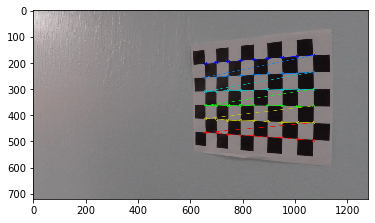

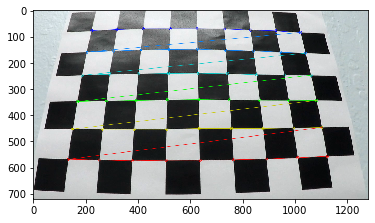

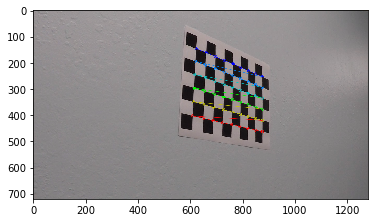

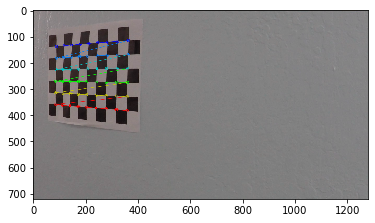

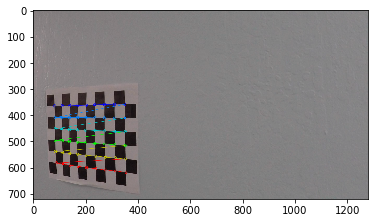

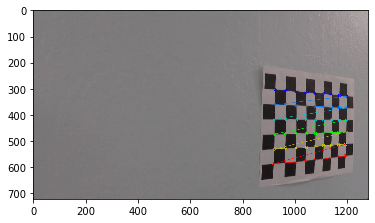

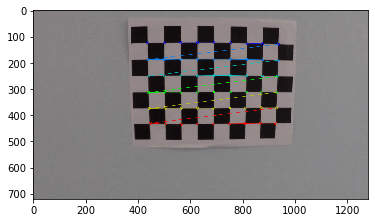

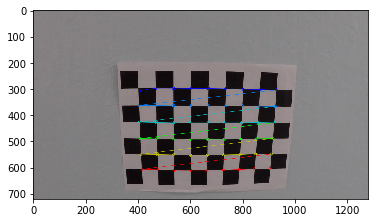

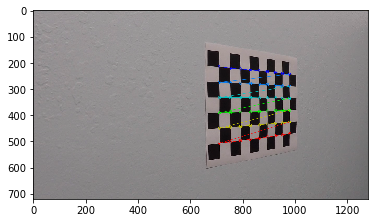

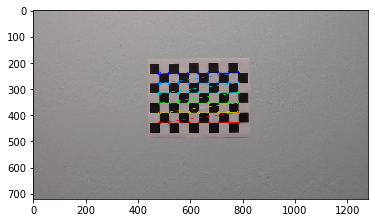

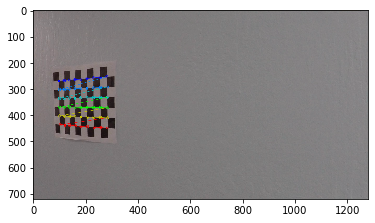

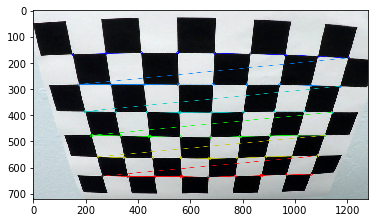

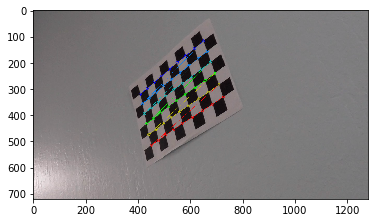

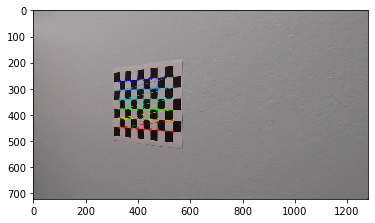

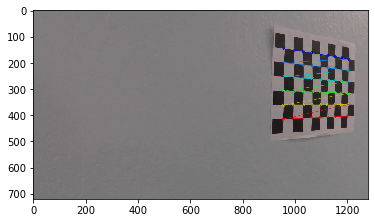

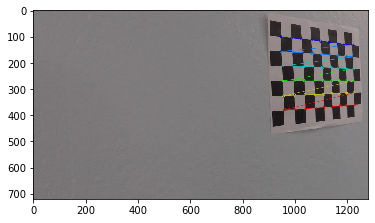

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib qt
%pylab inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')
gray = None
# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()

## Read Test Images



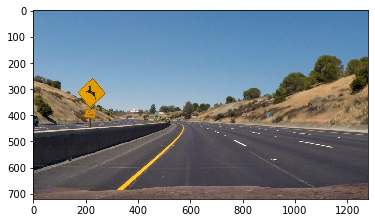

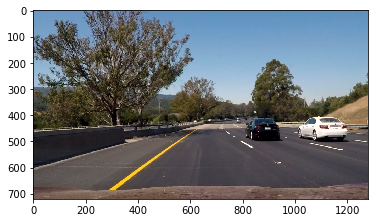

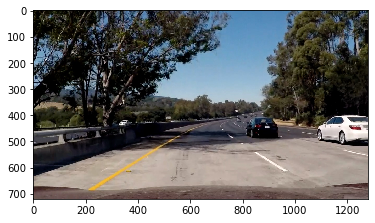

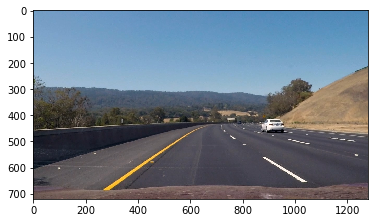

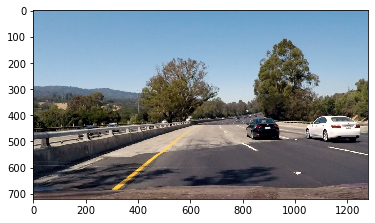

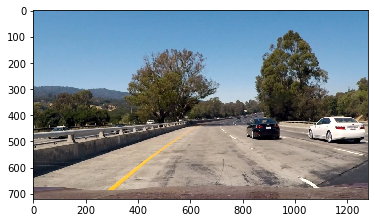

In [2]:
test_images_paths = glob.glob("./test_images/test*.jpg")
test_images = [plt.imread(fname) for fname in test_images_paths ]

for image in test_images:
    plt.imshow(image)
    plt.show()

## Undistort Test Images

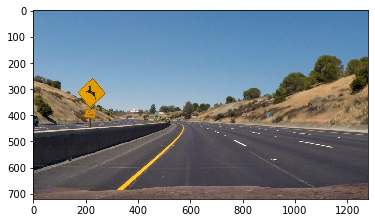

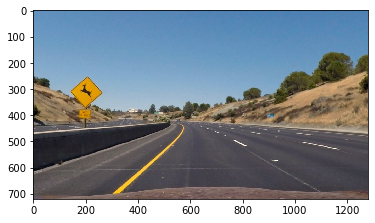

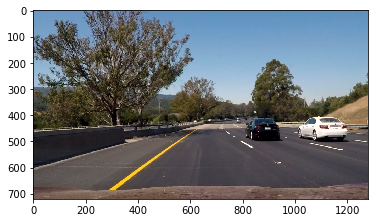

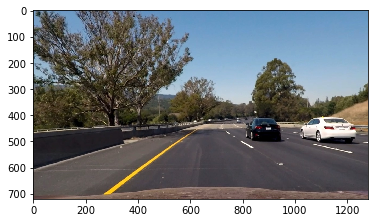

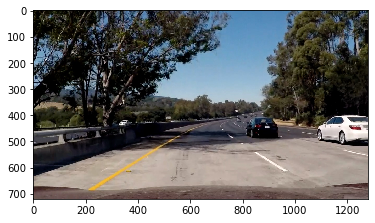

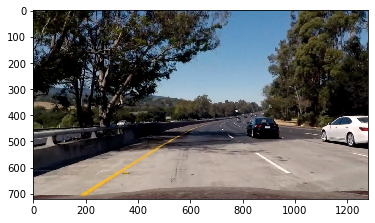

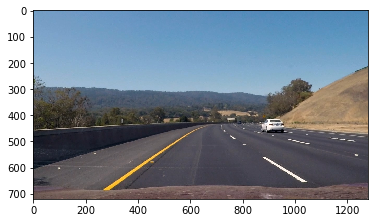

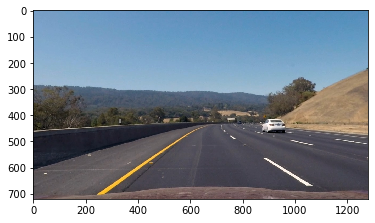

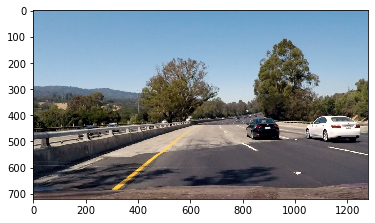

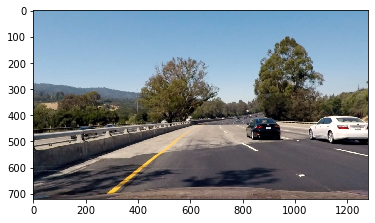

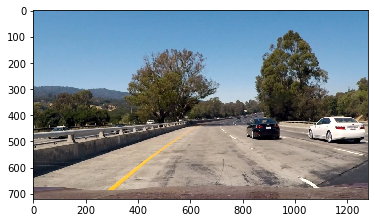

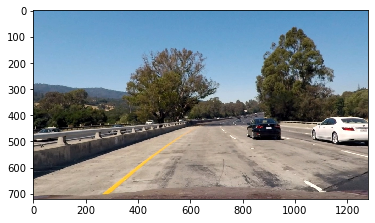

In [3]:

def cal_undistort(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

distorted_imgs = [cal_undistort(img, objpoints, imgpoints) for img in test_images]
for orj, distorted in zip(test_images, distorted_imgs):
        plt.imshow(orj)
        plt.show()
        plt.imshow(distorted)
        plt.show()

## Gradient Threshold Functions

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    if(orient =='x'):
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt(cv2.pow(sobelx,2) + cv2.pow(sobely,2))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobel = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(abs_sobel)
    binary_output[(abs_sobel >= thresh[0]) & (abs_sobel <= thresh[1])] = 1
    return binary_output

def combine_grad_threshold(image, ksize=3, abs_thres=(0,255),mag_thres=(0, 255), dir_thres=(0, np.pi/2)):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=abs_thres)
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=abs_thres)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, thresh=mag_thres)
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=dir_thres)
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined


## Color Threshold Functions

In [5]:
def hls_select(img, channel=2, thresh=(0, 255)):
    
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    channel = hls_img[:,:,channel]
    binary_output = np.zeros_like(channel) 
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

## Apply Threshold Filters To Images

In [6]:
hls_binaries =[hls_select(image, channel=2, thresh=(170, 255)) for image in distorted_imgs]
gray_images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in distorted_imgs]
thresholded_binaries =[combine_grad_threshold(image, ksize=3, abs_thres=(20,100),mag_thres=(100, 255), dir_thres=(0.3, 0.7)) for image in gray_images]


## Display Thresholded Images

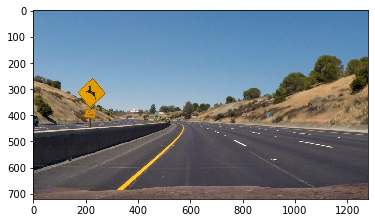

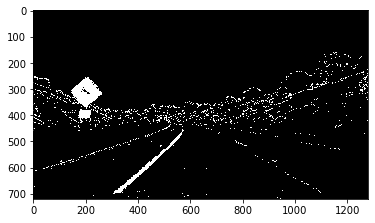

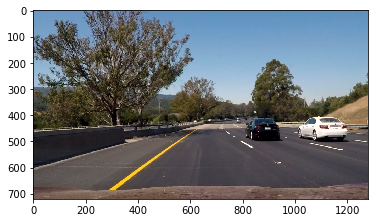

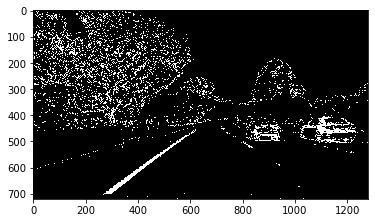

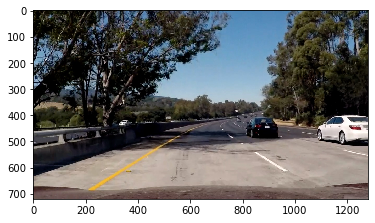

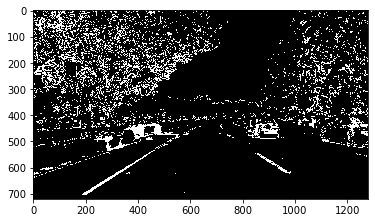

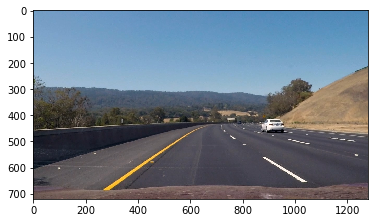

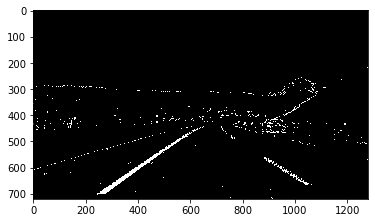

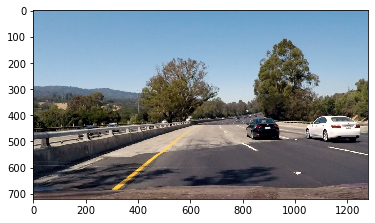

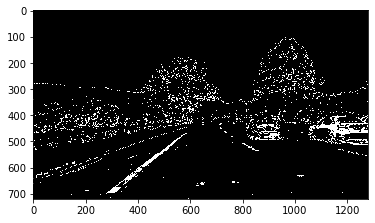

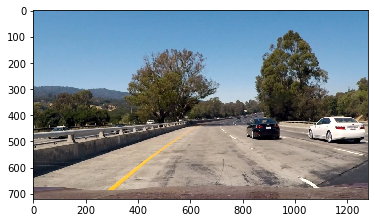

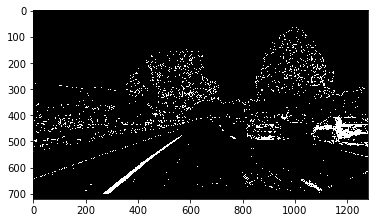

In [7]:
combined_threshold_binary_imgs = []
for hls, thresholded, orj in zip(hls_binaries, thresholded_binaries, test_images):
    combined_binary = np.zeros_like(hls)
    combined_binary[(hls == 1) | (thresholded == 1)] = 1
    plt.imshow(orj)
    plt.show()
    plt.imshow(combined_binary, cmap='gray')
    plt.show()
    combined_threshold_binary_imgs.append(combined_binary)

## Perspective Transform

In [8]:
def perspective_transform(image, src, dst):
    M = cv2.getPerspectiveTransform(src,dst)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

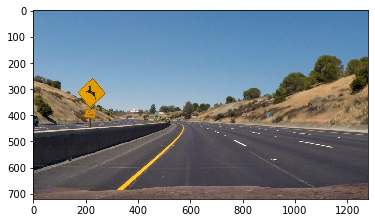

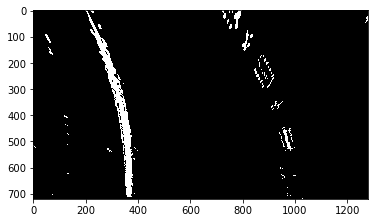

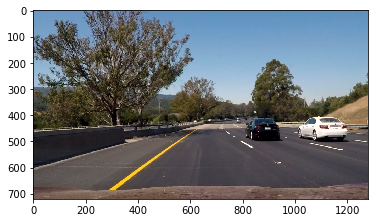

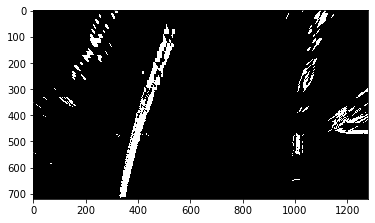

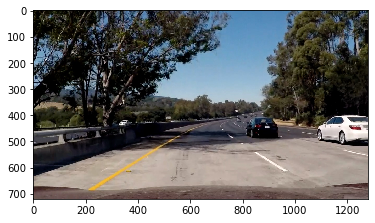

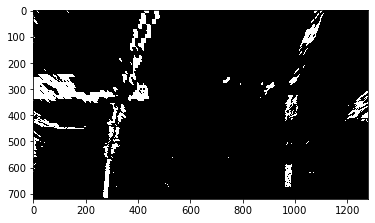

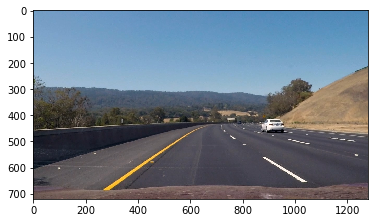

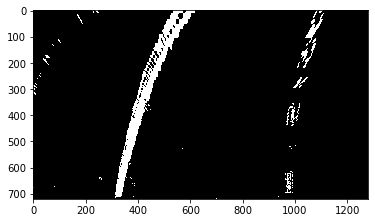

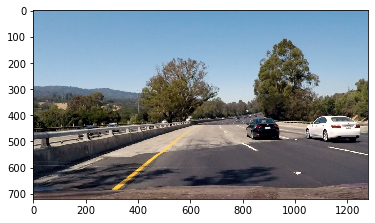

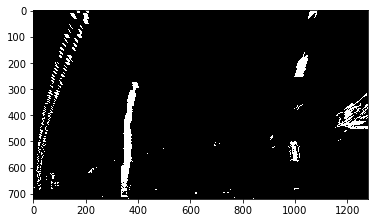

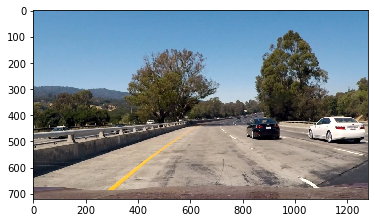

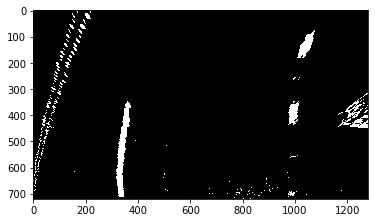

In [9]:
src = np.float32([(590,450), (700,450), (200, 720), (1130,720)])
dst = np.float32([[300, 0], [970, 0], [300, 720], [970, 720]])
perpective_transformed_images = [perspective_transform(img, src, dst) for img in combined_threshold_binary_imgs]
for image, orj in zip(perpective_transformed_images, test_images):
    plt.imshow(orj)
    plt.show()
    plt.imshow(image, cmap='gray')
    plt.show()


## Create Histogram 

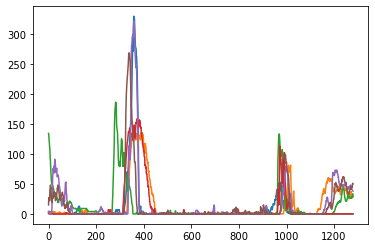

In [10]:
def hist(img):
    bottom_half = img[img.shape[0]//2:, : ]
    histogram = np.sum(bottom_half,axis=0)
    return histogram
histograms = [hist(img) for img in perpective_transformed_images]
for histogram in histograms:
    plt.plot(histogram)

## Find the Lines

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, visualize=False):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty


    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    if visualize:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(out_img)
        plt.show()
    return (left_fit, right_fit, ploty)

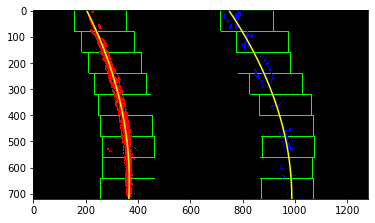

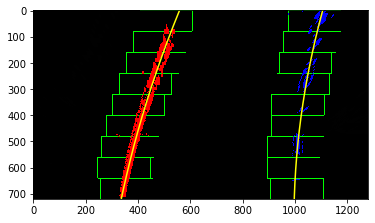

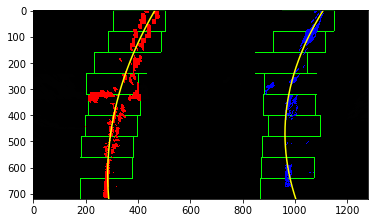

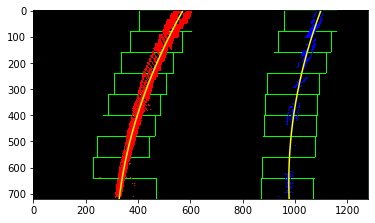

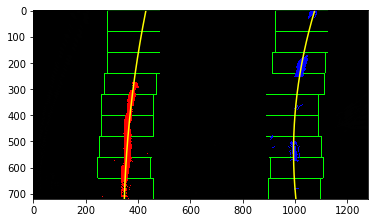

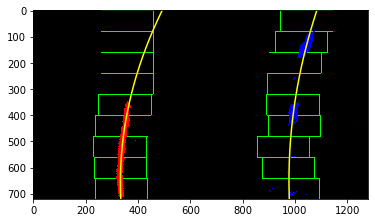

In [12]:
line_confs= [fit_polynomial(binary_warped, visualize=True) for binary_warped in perpective_transformed_images]   

## Search from Prior

In [13]:
def fit_poly(img_shape, left_fit, right_fit):
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, line_conf, visualize=False):
    # HYPERPARAMETER
    margin = 100
    
    # Grab activated pixels
    left_fit = line_conf[0]
    right_fit = line_conf[1]
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, left_fit, right_fit)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    if visualize:
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.imshow(result)
        plt.show()
    return (left_fit, right_fit, ploty)

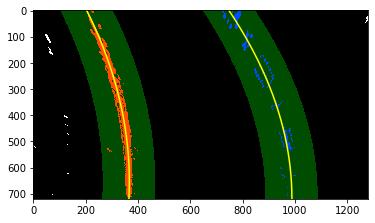

(array([-3.80371193e-04,  4.97333681e-01,  2.04063584e+02]),
 array([-4.64578026e-04,  6.68269183e-01,  7.47818090e+02]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
        121., 122., 123., 124., 125., 126., 127., 128., 129., 13

In [14]:
search_around_poly(perpective_transformed_images[0], line_confs[0], visualize=True)

## Measuring Curvature

In [15]:
def measure_curvature_pixels(line_conf):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    left_fit, right_fit, ploty = line_conf
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def measure_curvature_real(line_conf, ym_per_pix = 30/720, xm_per_pix = 3.7/700):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    left_fit, right_fit, ploty = line_conf
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix , leftx* xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    ploty= ploty*ym_per_pix
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

In [16]:
print(measure_curvature_real(line_confs[0]))

(433.5918459873202, 355.7188724176214)


## Lane Segmentation

In [17]:
def segment_lane(binary_warped, line_conf):
    # HYPERPARAMETER
    margin = 100
    
    # Grab activated pixels
    left_fit = line_conf[0]
    right_fit = line_conf[1]
    ploty = line_conf[2]
    # Fit new polynomials
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_window = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_window, right_line_window))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    result = cv2.addWeighted(np.zeros_like(out_img), 1, window_img, 0.3, 0)
    return result

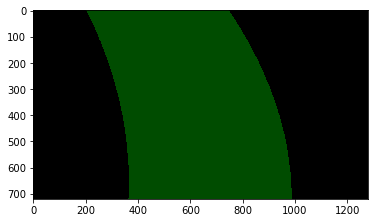

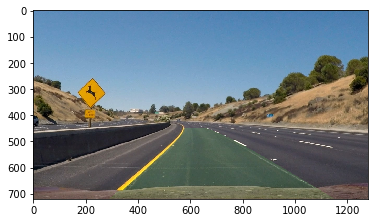

In [18]:
lane_mask = segment_lane(perpective_transformed_images[0], line_confs[0])

# View your output

newwarp = perspective_transform(lane_mask, dst, src)
# Combine the result with the original image
result = cv2.addWeighted(test_images[0], 1, newwarp, 0.3, 0)
plt.imshow(lane_mask)
plt.show()
plt.imshow(result)
plt.show()

## Pipeline for single image

In [19]:
def lane_detection(image, old_line_conf = None, visualize = False):
    distorted_img = cal_undistort(image, objpoints, imgpoints)
    gray_image = cv2.cvtColor(distorted_img, cv2.COLOR_RGB2GRAY)
    hls_binary = hls_select(distorted_img, channel=2, thresh=(170, 255))
    thresholded_binary = combine_grad_threshold(gray_image, ksize=3, abs_thres=(20,100),mag_thres=(100, 255), dir_thres=(0.3, 0.7))
    combined_binary = np.zeros_like(hls_binary)
    combined_binary[(hls_binary == 1) | (thresholded_binary == 1)] = 1
    src = np.float32([(590,450), (700,450), (200, 720), (1130,720)])
    dst = np.float32([[300, 0], [970, 0], [300, 720], [970, 720]])
    perpective_transformed_image = perspective_transform(combined_binary, src, dst)
    histogram = hist(perpective_transformed_image)
    if old_line_conf != None:
        line_conf = search_around_poly(perpective_transformed_image, old_line_conf)
    else:
        line_conf = fit_polynomial(perpective_transformed_image)
    old_line_conf = line_conf
    lane_mask = segment_lane(perpective_transformed_image, line_conf)
    newwarp = perspective_transform(lane_mask, dst, src)
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    if(visualize):
        plt.imshow(image)
        plt.show()
        plt.imshow(result)
        plt.show()
        print(measure_curvature_real(line_conf))
    return result, old_line_conf
    

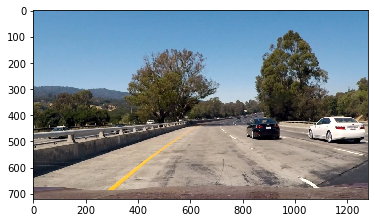

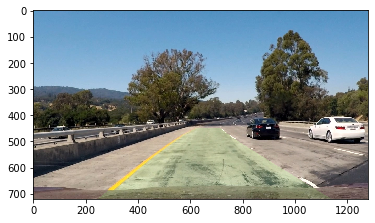

(445.4408340206883, 652.5376472824069)


(array([[[245, 235, 226],
         [242, 238, 235],
         [193, 206, 215],
         ...,
         [ 11,  36,  58],
         [ 16,  38,  59],
         [ 28,  49,  70]],
 
        [[242, 238, 235],
         [188, 193, 196],
         [139, 158, 173],
         ...,
         [ 74, 108, 135],
         [ 47,  77, 105],
         [  4,  34,  60]],
 
        [[190, 203, 212],
         [135, 157, 171],
         [118, 153, 181],
         ...,
         [ 96, 144, 182],
         [ 91, 136, 175],
         [ 52,  97, 136]],
 
        ...,
 
        [[142, 131, 129],
         [132, 121, 117],
         [114, 100,  97],
         ...,
         [ 99,  80,  74],
         [ 99,  80,  74],
         [113,  94,  88]],
 
        [[164, 154, 152],
         [133, 122, 118],
         [120, 106, 103],
         ...,
         [107,  88,  82],
         [109,  90,  84],
         [111,  92,  86]],
 
        [[189, 179, 177],
         [135, 126, 121],
         [130, 116, 113],
         ...,
         [ 97,  78,  72],
  

In [20]:
lane_detection(test_images[5], old_line_conf = None, visualize=True)

## Process video and save

In [ ]:
old_line_conf = None
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def process_image(image):
    global old_line_conf
    resulted_image, new_conf = lane_detection(image, old_line_conf = old_line_conf, visualize = False)
    old_line_conf = new_conf
    return resulted_image

video_file_name = "test_video"
white_output = './'+video_file_name+'_output.mp4'
clip1 = VideoFileClip('./'+video_file_name+'.mp4')
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)



t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./test_video_output.mp4.
Moviepy - Writing video ./test_video_output.mp4



t:  62%|██████▏   | 779/1260 [09:55<06:07,  1.31it/s, now=None]